# ASSIGNMENT 2 - ADVANCED MACHINE LEARNING
DANIELE MONTERISI - MAT. 853257 - DATA SCIENCE


<img src="https://eidonlab.org/wp-content/uploads/bfi_thumb/deep-learning-13fhvs9akzedl5wvbu1a4o96mg2pgro4th8eh2vnxfao2jm8.jpg" width="60%" />

> The assignment consists in the prediction of default payments using a neural network. The dataset contains information on default payments, demographic factors, credit data, history of payment, and bill statements of credit card clients in Taiwan from April 2005 to September 2005.  The provided data comprises the training set that can be used for the training (and eventually for the validation) and the unlabelled test set.





## Import Libraries



In [1]:
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import fashion_mnist
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers.core import Dense, Dropout
from keras.optimizers import SGD
from sklearn.model_selection import train_test_split
from tensorflow.keras import regularizers
from keras.backend import abs, sum
import keras.backend as K
import tensorflow as tf
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn import preprocessing
import os 
from google.colab import drive
import seaborn as sns
from keras.initializers import glorot_uniform
from keras.utils.generic_utils import get_custom_objects
from keras.layers import Activation, LeakyReLU
from tensorflow.keras.activations import sigmoid

pd.set_option('display.max_columns', None)

%matplotlib inline

Here we declare the value of the constant that represents the number of training epochs of the neural network

In [2]:
EPOCHS = 30

In the following chunk we define the function that allows to obtain the value of the F1 score metric to compare the performance of various configurations of the neural network.

In [3]:
def get_f1(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In the following chunk we define the function that allows to visualize through a plot the performances obtained from various configurations of the neural network.

In [4]:
def plot_history(network_history):
    x_plot = list(range(1,EPOCHS+1))
    plt.style.use('dark_background')
    plt.figure()
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.plot(x_plot, network_history.history['loss'])
    plt.plot(x_plot, network_history.history['val_loss'])
    plt.legend(['Training', 'Validation'])
    plt.style.use('dark_background')
    

    plt.figure()
    plt.xlabel('Epochs')
    plt.ylabel('f1')
    plt.plot(x_plot, network_history.history['get_f1'])
    plt.plot(x_plot, network_history.history['val_get_f1'])
    plt.legend(['Training', 'Validation'], loc='lower right')

    
    plt.show()

In the following code we define the function to have the f1 score of each activation function.

In [5]:
def risultati_f1(activation_function, f1):
    for i in range(len(activation_function)):
        print('F1 score of the activation function {} is {}'.format(activation_function[i], round(f1[i], 7)))


In the following code we define the function to have the f1 score plot of each activation function.

In [16]:
f1_finale = []

def plot_act_func_results(results, activation_functions = []):
  
    plt.figure(figsize=(10,7))
    plt.style.use('dark_background')
    
    # Plot of the validation root mean squared error
    plt.figure(figsize=(10,10))
    
    for act_func in results:
        plt.plot(act_func.history['val_get_f1'])
        f1_finale.append(act_func.history['val_get_f1'][-1])
    
    plt.title('Model F1 score')
    plt.ylabel('Validation F1 score')
    plt.xlabel('Epoch')
    plt.legend(activation_functions)
    plt.show()

#**Import data**

In [7]:
drive.mount('/content/drive')
os.chdir('/content/drive/My Drive/Advanced Machine Learning/Assignment 2')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


We use the X_train and Y_train dataset to train the neural network. Predictions will be made on X_test dataset.

In [8]:
X_train = pd.read_csv("X_train.csv")
Y_train = pd.read_csv("y_train.csv")
X_test = pd.read_csv("X_test.csv")

Y_train= Y_train.drop(columns='ID')
X_train= X_train.drop(columns='ID')
X_test= X_test.drop(columns='ID')

We divide the partitions of the train in order to get the partitions for validation.

<img src="https://miro.medium.com/max/1552/1*Nv2NNALuokZEcV6hYEHdGA.png" width="40%" />

In [9]:
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train)

Now we standardise the data, i.e. scaling the average and the variance so that they are 0 and 1 respectively.

In [10]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_val = sc.transform(X_val)
X_test = sc.transform(X_test)

We transform Y into categorical variables.

In [11]:
Y_train =  np_utils.to_categorical(Y_train, 2)
Y_val = np_utils.to_categorical(Y_val, 2)

# Fully-connected Neural Network

To identify the model that achieves the best performance in terms of F1 score, we use various activation functions.

In [12]:
# Add the GELU function

def gelu(x):
    return 0.5 * x * (1 + tf.tanh(tf.sqrt(2 / np.pi) * (x + 0.044715 * tf.pow(x, 3))))
get_custom_objects().update({'gelu': Activation(gelu)})

# Add the alpha parameter of the Leaky-Relu function

get_custom_objects().update({'leaky-relu': Activation(LeakyReLU(alpha=0.2))})

# Add the Swish function

def swish(x, beta = 1):
    return (x * sigmoid(beta * x))
get_custom_objects().update({'swish': Activation(swish)})

act_func = ['relu', 'elu', 'leaky-relu', 'selu', 'gelu', 'swish']

In [13]:
result = []
for activation in act_func:
    print('\nTraining with -->{0}<-- activation function\n'.format(activation))


    dims = X_train.shape[1]

    nb_classes = 2

    initializer = tf.keras.initializers.GlorotUniform(seed=1234) 


    model = Sequential()
    model.add(Dense(512, input_shape=(dims,), activation = activation , kernel_initializer=initializer))
    model.add(Dense(256, activation = activation, kernel_initializer=initializer))
    model.add(Dense(32, activation = activation, kernel_initializer=initializer))
    model.add(Dense(16, activation = activation, kernel_initializer=initializer))
    model.add(Dense(nb_classes, activation = "sigmoid", kernel_initializer=initializer))


    model.compile(optimizer="adam", loss='binary_crossentropy',metrics=[get_f1])
    network_history = model.fit(X_train, Y_train, batch_size=512, 
                            epochs=EPOCHS, verbose=0, validation_data=( X_val, Y_val))

    result.append(network_history)
    K.clear_session()
    del model



Training with -->relu<-- activation function


Training with -->elu<-- activation function


Training with -->leaky-relu<-- activation function


Training with -->selu<-- activation function


Training with -->gelu<-- activation function


Training with -->swish<-- activation function



<Figure size 720x504 with 0 Axes>

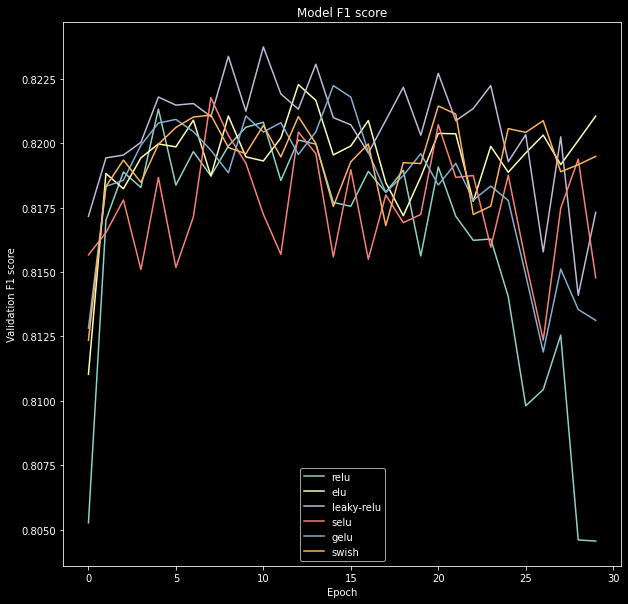

In [17]:
plot_act_func_results(result, act_func)

In [18]:
risultati_f1(act_func, f1_finale)

F1 score of the activation function relu is 0.8045526
F1 score of the activation function elu is 0.8210599
F1 score of the activation function leaky-relu is 0.8173241
F1 score of the activation function selu is 0.8147812
F1 score of the activation function gelu is 0.8131264
F1 score of the activation function swish is 0.8194973


With the ELU activation function you get the highest F1 value.

# Fully-connected Neural Network - ELU


We recreate the model using the elu function.

In [19]:
dims = X_train.shape[1]

nb_classes = 2

initializer = tf.keras.initializers.GlorotUniform(seed=1234) 


model = Sequential()
model.add(Dense(512, input_shape=(dims,), activation = "elu" , kernel_initializer=initializer))
model.add(Dense(256, activation = "elu" , kernel_initializer=initializer))
model.add(Dense(32, activation = "elu" , kernel_initializer=initializer))
model.add(Dense(16, activation = "elu" , kernel_initializer=initializer))
model.add(Dense(nb_classes, activation = "sigmoid", kernel_initializer=initializer))


model.compile(optimizer="adam", loss='binary_crossentropy',metrics=[get_f1])

network_history = model.fit(X_train, Y_train, batch_size=512, 
                            epochs=EPOCHS, verbose=1, validation_data=(X_val, Y_val))

Epoch 1/30
36/36 [==============================] - 1s 18ms/step - loss: 0.5198 - get_f1: 0.7702 - val_loss: 0.4591 - val_get_f1: 0.8150
Epoch 2/30
36/36 [==============================] - 0s 14ms/step - loss: 0.4502 - get_f1: 0.8169 - val_loss: 0.4525 - val_get_f1: 0.8151
Epoch 3/30
36/36 [==============================] - 0s 14ms/step - loss: 0.4417 - get_f1: 0.8190 - val_loss: 0.4444 - val_get_f1: 0.8183
Epoch 4/30
36/36 [==============================] - 1s 14ms/step - loss: 0.4380 - get_f1: 0.8177 - val_loss: 0.4422 - val_get_f1: 0.8219
Epoch 5/30
36/36 [==============================] - 1s 15ms/step - loss: 0.4353 - get_f1: 0.8192 - val_loss: 0.4398 - val_get_f1: 0.8235
Epoch 6/30
36/36 [==============================] - 1s 14ms/step - loss: 0.4330 - get_f1: 0.8183 - val_loss: 0.4357 - val_get_f1: 0.8225
Epoch 7/30
36/36 [==============================] - 0s 14ms/step - loss: 0.4314 - get_f1: 0.8187 - val_loss: 0.4380 - val_get_f1: 0.8157
Epoch 8/30
36/36 [=======================

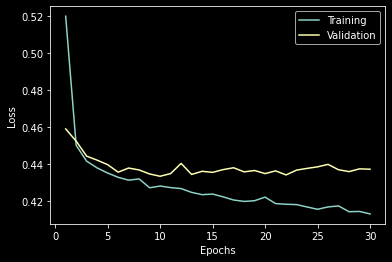

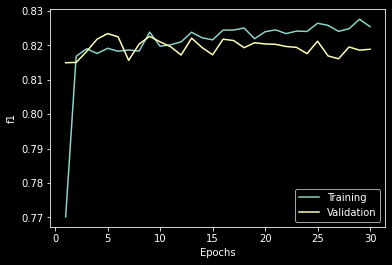

In [20]:
plot_history(network_history)

In [21]:
best_score = max(network_history.history["get_f1"])

print(best_score)

0.8276243209838867


#Regularization L1


Applying L1 regularization to the kernel. New loss function:

$$L(x,y) = L(x,y) + \lambda\sum_{j=0}^{M}|W_j|$$

where:
*   $\lambda$ parameter controls the impact of regularization
*   $W$ corresponds to the model weights


We set a small penalty value of 0.01

In [22]:
model_l1 = Sequential()
model_l1.add(Dense(512, input_shape=(dims,), activation = "elu",kernel_initializer=initializer, kernel_regularizer=regularizers.l1(0.01)))
model_l1.add(Dense(256, activation = "elu", kernel_initializer=initializer, kernel_regularizer=regularizers.l1(0.01)))
model_l1.add(Dense(32, activation = "elu", kernel_initializer=initializer, kernel_regularizer=regularizers.l1(0.01)))
model_l1.add(Dense(16, activation = "elu", kernel_initializer=initializer, kernel_regularizer=regularizers.l1(0.01)))
model_l1.add(Dense(nb_classes, activation = "sigmoid", kernel_initializer=initializer))

model_l1.compile(loss='binary_crossentropy', optimizer="adam", 
              metrics=[get_f1])
network_history_l1= model_l1.fit(X_train, Y_train, batch_size=512, 
                            epochs=EPOCHS, verbose=1, validation_data=(X_val, Y_val))

Epoch 1/30
36/36 [==============================] - 1s 19ms/step - loss: 49.3701 - get_f1: 0.7241 - val_loss: 28.3842 - val_get_f1: 0.7743
Epoch 2/30
36/36 [==============================] - 1s 15ms/step - loss: 15.9918 - get_f1: 0.7776 - val_loss: 6.0876 - val_get_f1: 0.7745
Epoch 3/30
36/36 [==============================] - 1s 14ms/step - loss: 3.2369 - get_f1: 0.7770 - val_loss: 1.7654 - val_get_f1: 0.7745
Epoch 4/30
36/36 [==============================] - 1s 14ms/step - loss: 1.3340 - get_f1: 0.7785 - val_loss: 1.0786 - val_get_f1: 0.7745
Epoch 5/30
36/36 [==============================] - 1s 15ms/step - loss: 0.9978 - get_f1: 0.7790 - val_loss: 0.9383 - val_get_f1: 0.7745
Epoch 6/30
36/36 [==============================] - 1s 15ms/step - loss: 0.8900 - get_f1: 0.7796 - val_loss: 0.8527 - val_get_f1: 0.7745
Epoch 7/30
36/36 [==============================] - 1s 14ms/step - loss: 0.8166 - get_f1: 0.7790 - val_loss: 0.7917 - val_get_f1: 0.7745
Epoch 8/30
36/36 [====================

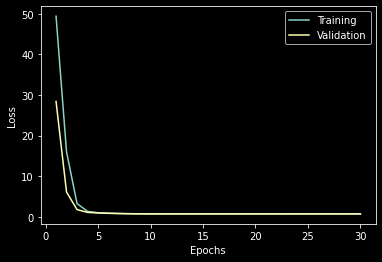

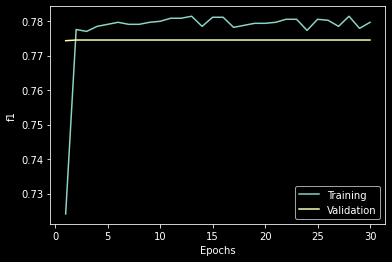

In [23]:
plot_history(network_history_l1)

#Regularization L2


Applying L2 regularization to the kernel. New loss function: $$L(x,y) = L(x,y) + \lambda\sum_{j=0}^{M}W_j^2$$

where:
*   $\lambda$ parameter controls the impact of regularization
*   $W$ corresponds to the model weights

We set a small penalty value of 0.01

In [24]:
model_l2 = Sequential()
model_l2.add(Dense(512, input_shape=(dims,), activation = "elu", kernel_initializer=initializer, kernel_regularizer=regularizers.l2(0.01)))
model_l2.add(Dense(256, activation = "elu", kernel_initializer=initializer, kernel_regularizer=regularizers.l2(0.01)))
model_l2.add(Dense(32, activation = "elu", kernel_initializer=initializer, kernel_regularizer=regularizers.l2(0.01)))
model_l2.add(Dense(16, activation = "elu", kernel_initializer=initializer, kernel_regularizer=regularizers.l2(0.01)))
model_l2.add(Dense(nb_classes, activation = "sigmoid"))

model_l2.compile(loss='binary_crossentropy', optimizer="adam", 
              metrics=[get_f1])
network_history_l2=model_l2.fit(X_train, Y_train, batch_size=512, 
                            epochs=EPOCHS, verbose=1, validation_data=(X_val, Y_val))

Epoch 1/30
36/36 [==============================] - 1s 18ms/step - loss: 3.5361 - get_f1: 0.7885 - val_loss: 2.0865 - val_get_f1: 0.8160
Epoch 2/30
36/36 [==============================] - 1s 15ms/step - loss: 1.4529 - get_f1: 0.8157 - val_loss: 0.9893 - val_get_f1: 0.8125
Epoch 3/30
36/36 [==============================] - 1s 15ms/step - loss: 0.8076 - get_f1: 0.8147 - val_loss: 0.6755 - val_get_f1: 0.8113
Epoch 4/30
36/36 [==============================] - 1s 14ms/step - loss: 0.6214 - get_f1: 0.8118 - val_loss: 0.5796 - val_get_f1: 0.8104
Epoch 5/30
36/36 [==============================] - 1s 14ms/step - loss: 0.5583 - get_f1: 0.8098 - val_loss: 0.5426 - val_get_f1: 0.8014
Epoch 6/30
36/36 [==============================] - 1s 14ms/step - loss: 0.5312 - get_f1: 0.8079 - val_loss: 0.5228 - val_get_f1: 0.8036
Epoch 7/30
36/36 [==============================] - 1s 15ms/step - loss: 0.5171 - get_f1: 0.8092 - val_loss: 0.5108 - val_get_f1: 0.8127
Epoch 8/30
36/36 [=======================

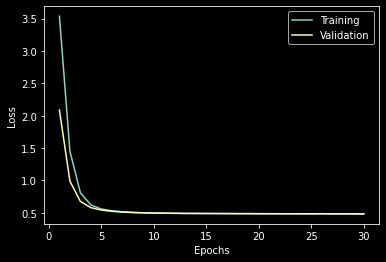

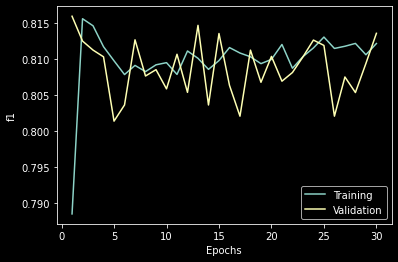

In [25]:
plot_history(network_history_l2)

#Impact of regularization

We can observe the impact of regularization on weights:

In [ ]:
print('Sum of the values of the weights without regularization:', sum(abs(model.weights[6][0])).numpy() + sum(abs(model.weights[7][0])).numpy())
print('Sum of the values of the weights with regularization l2:', sum(abs(model_l2.weights[6][0])).numpy() + sum(abs(model_l2.weights[7][0])).numpy())
print('Sum of the values of the weights with regularization l1:', sum(abs(model_l1.weights[6][0])).numpy() + sum(abs(model_l1.weights[7][0])).numpy())

Sum of the values of the weights without regularization: 2.9291675
Sum of the values of the weights with regularization l2: 0.25017425
Sum of the values of the weights with regularization l1: 0.19576071


# DROPOUT


Now let's use the dropout method that consists of random exclusion of network units.

<img src="https://miro.medium.com/proxy/1*iWQzxhVlvadk6VAJjsgXgg.png" width="30%" />


In [26]:
initializer = tf.keras.initializers.GlorotUniform(seed=1234)


model_d = Sequential()
model_d.add(Dense(512, input_shape=(dims,), activation = "elu", kernel_initializer=initializer))
model_d.add(Dense(256, activation = "elu", kernel_initializer=initializer))
model_d.add(Dropout(0.1))
model_d.add(Dense(32, activation = "elu", kernel_initializer=initializer))
model_d.add(Dropout(0.1))
model_d.add(Dense(16, activation = "elu", kernel_initializer=initializer))
model_d.add(Dropout(0.1))
model_d.add(Dense(nb_classes, activation = "sigmoid", kernel_initializer=initializer))


model_d.compile(optimizer="adam", loss='binary_crossentropy',metrics=[get_f1])


In [27]:
network_history_drop = model_d.fit(X_train, Y_train, batch_size=512, 
                            epochs=EPOCHS, verbose=1, validation_data=(X_val, Y_val))

Epoch 1/30
36/36 [==============================] - 1s 20ms/step - loss: 0.5348 - get_f1: 0.7622 - val_loss: 0.4665 - val_get_f1: 0.8139
Epoch 2/30
36/36 [==============================] - 1s 16ms/step - loss: 0.4651 - get_f1: 0.8114 - val_loss: 0.4473 - val_get_f1: 0.8154
Epoch 3/30
36/36 [==============================] - 1s 16ms/step - loss: 0.4547 - get_f1: 0.8146 - val_loss: 0.4514 - val_get_f1: 0.8143
Epoch 4/30
36/36 [==============================] - 1s 16ms/step - loss: 0.4522 - get_f1: 0.8138 - val_loss: 0.4412 - val_get_f1: 0.8188
Epoch 5/30
36/36 [==============================] - 1s 16ms/step - loss: 0.4465 - get_f1: 0.8187 - val_loss: 0.4395 - val_get_f1: 0.8201
Epoch 6/30
36/36 [==============================] - 1s 16ms/step - loss: 0.4450 - get_f1: 0.8172 - val_loss: 0.4417 - val_get_f1: 0.8182
Epoch 7/30
36/36 [==============================] - 1s 16ms/step - loss: 0.4433 - get_f1: 0.8147 - val_loss: 0.4358 - val_get_f1: 0.8213
Epoch 8/30
36/36 [=======================

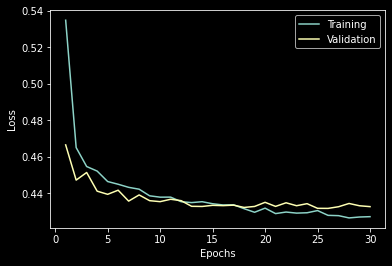

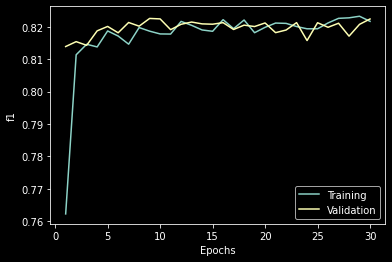

In [28]:
plot_history(network_history_drop)

#Results and conclusions

In [29]:
results = {
  "Type" : ['Without regularization', 'L1 regularization','L2 regularization', 'Dropout'],
  "F1-score" : [max(network_history.history['get_f1']), max(network_history_l1.history['get_f1']),max(network_history_l2.history['get_f1']), max(network_history_drop.history['get_f1']) ]

}

df_results = pd.DataFrame(results)
df_results

,Type,F1-score
0,Without regularization,0.827624
1,L1 regularization,0.781391
2,L2 regularization,0.815658
3,Dropout,0.823276


The L2 regularization has produced better results than the L1 regularization. However, the Dropout achieved better results than the regularization by obtaining an F1 score value very close to the value obtained by the model without regularizations. In fact, the latter has proven to be the most effective model in terms of F1 measurement. 

#Testing and forecasting

In [30]:
Y_pred = model.predict(X_test)


In [31]:
y_classes = Y_pred.argmax(axis=-1)

In [32]:
y_classes

array([0, 0, 0, ..., 0, 0, 0])

In [33]:
np.savetxt("forecsts.txt", y_classes, "%i")